In [62]:
from model import Model
from data_customize import DataModule
import torch
from torchvision.io import read_image
from torchvision.transforms import Resize
import numpy
import matplotlib.pyplot as plt
import copy

In [63]:
data = DataModule(batch_size = 4, num_workers = 0);
data.setup('test')
model = Model()
model.load_state_dict(torch.load('model_detect_corner_with_labels.pth', weights_only=True))
model.freeze()

In [64]:
predictions = []
true_labels = []
for x, y in data.test_data:
    predictions.append(model(x.unsqueeze(0)))
    true_labels.append(y)
for x, y in data.validate_data:
    predictions.append(model(x.unsqueeze(0)))
    true_labels.append(y)

In [65]:
def L2(x, y):
    return numpy.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)

def origin(box):
    return [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]

def min_distance(predict_box, boxes):
    min_index, distance = 0, 1e9;
    for index, other_box in enumerate(boxes):
        if L2(origin(predict_box), origin(other_box)) < distance:
            distance = L2(origin(predict_box), origin(other_box))
            min_index = index
    return min_index, distance

def find_true_class_of_predictions(temp_predictions, threshold = 15):
    true_class_of_predictions = copy.deepcopy(temp_predictions)
    for data_index, prediction in enumerate(true_class_of_predictions):
        true_class_of_predictions[data_index][0]['distance'] = [0 for i in range(len(prediction[0]['boxes']))]
        for label_index, label in enumerate(prediction[0]['boxes']): 
            min_index, distance = min_distance(label, true_labels[data_index]['boxes']);
            if distance < threshold:
                true_class_of_predictions[data_index][0]['labels'][label_index] = true_labels[data_index]['labels'][min_index]
            else:
                true_class_of_predictions[data_index][0]['labels'][label_index] = 0
            true_class_of_predictions[data_index][0]['distance'][label_index] = distance.item()

    return true_class_of_predictions


In [66]:
print(predictions, true_labels)

[[{'boxes': tensor([[465.5719, 380.7354, 525.6309, 441.2711],
        [ 36.2374, 202.7559,  96.2728, 263.1777],
        [ 63.6486, 394.3662, 122.7467, 454.1600],
        [493.9455, 208.4483, 554.1647, 269.0904],
        [  0.0000, 185.5467,  40.5750, 245.9048],
        [ 62.5845, 394.7467, 122.5689, 454.7316],
        [ 63.0568, 393.9767, 123.1277, 453.9672],
        [463.7626, 380.4051, 524.2006, 440.6011],
        [151.3329,  32.7337, 211.6349,  91.6900],
        [600.3600, 210.2631, 640.0000, 270.7686],
        [473.9214, 202.9329, 534.0132, 262.0100],
        [465.0512, 380.4163, 525.3351, 439.9557],
        [ 62.8818, 393.5735, 122.8742, 453.2725],
        [  0.0000, 179.7545,  25.0442, 237.0034],
        [163.4147,  22.0575, 223.8040,  80.6505],
        [ 36.6527, 202.2964,  96.5715, 262.5078],
        [463.7626, 380.4051, 524.2006, 440.6011],
        [600.3600, 210.2631, 640.0000, 270.7686]]), 'scores': tensor([0.9940, 0.9869, 0.9611, 0.9212, 0.2417, 0.1618, 0.1426, 0.1287, 0.11

In [67]:
true_class = find_true_class_of_predictions(predictions)
print(true_class)

[[{'boxes': tensor([[465.5719, 380.7354, 525.6309, 441.2711],
        [ 36.2374, 202.7559,  96.2728, 263.1777],
        [ 63.6486, 394.3662, 122.7467, 454.1600],
        [493.9455, 208.4483, 554.1647, 269.0904],
        [  0.0000, 185.5467,  40.5750, 245.9048],
        [ 62.5845, 394.7467, 122.5689, 454.7316],
        [ 63.0568, 393.9767, 123.1277, 453.9672],
        [463.7626, 380.4051, 524.2006, 440.6011],
        [151.3329,  32.7337, 211.6349,  91.6900],
        [600.3600, 210.2631, 640.0000, 270.7686],
        [473.9214, 202.9329, 534.0132, 262.0100],
        [465.0512, 380.4163, 525.3351, 439.9557],
        [ 62.8818, 393.5735, 122.8742, 453.2725],
        [  0.0000, 179.7545,  25.0442, 237.0034],
        [163.4147,  22.0575, 223.8040,  80.6505],
        [ 36.6527, 202.2964,  96.5715, 262.5078],
        [463.7626, 380.4051, 524.2006, 440.6011],
        [600.3600, 210.2631, 640.0000, 270.7686]]), 'scores': tensor([0.9940, 0.9869, 0.9611, 0.9212, 0.2417, 0.1618, 0.1426, 0.1287, 0.11

In [68]:
def draw_ROC_cls(cls):
    TPR = []
    FPR = []
    for threshold in range(101):
        threshold = float(threshold) / float(100)
        
        FP, FN, TP, TN = 0, 0, 0, 0
        for data_index, prediction in enumerate(true_class):
             for label_index, label in enumerate(prediction[0]['labels']):
                predicted = predictions[data_index][0]['labels'][label_index]
                true_label = label
                score = prediction[0]['scores'][label_index]
                if score > threshold:
                    if true_label == cls:
                        #print(predicted)
                        if predicted == cls:
                            TP += 1;
                        else:
                            FN += 1;
                    else:
                        if predicted == cls:
                            FP += 1;
                        else:
                            TN += 1;

        #print(TP, FP, TN, FN)
        TPR.append(0 if TP + FN == 0 else TP / (TP + FN))
        FPR.append(0 if FP + TN == 0 else FP / (FP + TN))
    # TPR = numpy.array(TPR)
    # FPR = numpy.array(FPR)
    # index = TPR.argsort()
    # TPR = TPR[index]
    # FPR = FPR[index]
    plt.plot(TPR, FPR)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.show()

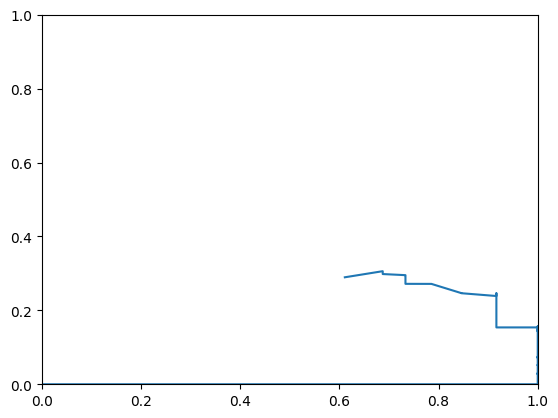

In [69]:
draw_ROC_cls(4)

In [70]:
def acc(thres, bin = False):
    cnt = 0;
    correct = 0;
    time_appear = [0 for i in range(4)];
    for data_index, prediction in enumerate(true_class):
        is_appear = [False for i in range(4)]
        for label_index, label in enumerate(prediction[0]['labels']):
            predicted = predictions[data_index][0]['labels'][label_index]
            true_label = label
            score = prediction[0]['scores'][label_index]
            if score > thres:
                cnt += 1;
                #print(data_index, predicted, true_label)
                if (predicted == true_label if bin == False else predicted > 0):
                    is_appear[true_label - 1] = True
                    correct += 1;
            
        for i in range(4):
            if is_appear[i]:
                time_appear[i] += 1;
            else:
                #print(i, data_index)
                pass
    for i in range(4):
        time_appear[i] = time_appear[i] / len(true_class)
    return correct / cnt, time_appear;

def distance(thres):
    cnt = 0;
    dis = 0;
    for data_index, prediction in enumerate(true_class):
        for label_index, label in enumerate(prediction[0]['labels']):
            predicted = predictions[data_index][0]['labels'][label_index]
            true_label = label
            score = prediction[0]['scores'][label_index]
            if score > thres:
                if predicted > 0:
                    cnt += 1;
                    dis += prediction[0]['distance'][label_index];

    return dis / cnt;

In [71]:
print(distance(0.8))
print(acc(0.8, True))

17.124341575225294
(1.0, [0.8181818181818182, 1.0, 0.9090909090909091, 1.0])
